In [3]:
#IMPORT ALL PYTHON PACKAGES
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import os
import random
import re
from itertools import cycle, product
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from IPython.display import display
from keras.layers import LSTM, Dense
from keras import Sequential
from keras.backend import clear_session
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from scipy.special import boxcox1p, inv_boxcox1p
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


In [4]:
#PACKAGE UNTUK CONNECT G-DRIVE N G-COLLAB 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOAD DATASET

In [5]:
df_order = pd.read_csv('/content/drive/MyDrive/Dataset/orders_dataset.csv')
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [6]:
#check the dataset
df_order

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [7]:
order_date = pd.to_datetime(df_order['order_purchase_timestamp']).dt.date
first_date = order_date.min() # search for start date
last_date = order_date.max()  # search for last date
date = pd.date_range(first_date, last_date, normalize="True")
date

DatetimeIndex(['2016-09-04', '2016-09-05', '2016-09-06', '2016-09-07',
               '2016-09-08', '2016-09-09', '2016-09-10', '2016-09-11',
               '2016-09-12', '2016-09-13',
               ...
               '2018-10-08', '2018-10-09', '2018-10-10', '2018-10-11',
               '2018-10-12', '2018-10-13', '2018-10-14', '2018-10-15',
               '2018-10-16', '2018-10-17'],
              dtype='datetime64[ns]', length=774, freq='D')

In [8]:
order_date= (
    order_date.value_counts(sort =False).sort_index().reindex(date, fill_value=0)
)

# Grpahic Orders per Day
FInding:
1.   The Pattern on Sep-Oct 2016 and Sep-Oct 2017 is same
2.   So, we can assume 24 Nov 2019 the pattern will same like 24 November 2018 (High Demand)



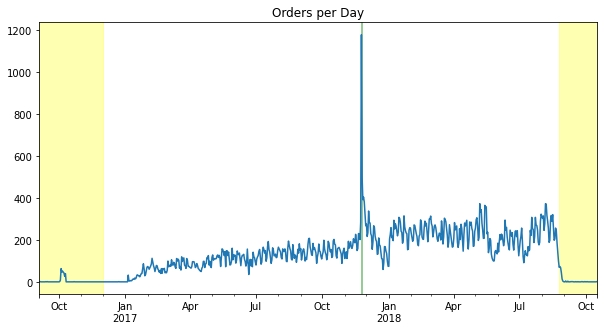

In [17]:
fig, ax=plt.subplots(figsize=(10,5))
order_date.plot(ax=ax)
ax.axvspan(datetime.date(2016, 6, 1), datetime.date(2016, 12, 1), color='yellow', alpha=0.3)
ax.axvspan(datetime.date(2017, 11, 24), datetime.date(2017, 11, 25), color='green', alpha=0.3)
ax.axvspan(datetime.date(2018, 8, 25), datetime.date(2018, 10, 17), color='yellow', alpha=0.3)
ax.set_title('Orders per Day')
plt.show()


# **PREDICT**

In [27]:
#CREATE FUNCTION FOR PREDICT
result = pd.DataFrame(columns=['algo', 'mse'])
def plot(index, pred, mse, title, fig=None, ax=None):
    global history
    empty_fig = fig is None
    if empty_fig:
        fig, ax = plt.subplots(figsize=(13, 6))
        ax.set_title(title + ': Last Fold CV In-Sample Forecasting')
    else:
        ax.set_title(title)
        models = ['', 'STL', 'Boxcox', 'Seasonal Diff']
        ylabels = ['Original', 'Deseasonal', 'Boxcox', 'Stationary']
        for model, ylabel in zip(models, ylabels):
            if re.sub(r'[^\+]+(\s\+\s)?([^\+]+)?$', r'\g<2>', title) == model:
                ax.set_ylabel(ylabel)
    patch_ = mpatches.Patch(color='white', label=f'MSE: {np.mean(mse):.1e}')
    L1 = ax.legend(handles=[patch_], loc='upper left', fancybox=True, framealpha=0.7,  handlelength=0)
    ax.add_artist(L1)
    sns.lineplot(x=history.index, y=history, label='true', ax=ax)
    sns.lineplot(x=index, y=pred, label='pred', ax=ax)
    ax.axvline(x=index[0], color='red')
    ax.legend(loc='upper right')
    if empty_fig:
        plt.show()
    else:
        return fig

def record(algo, mse):
    global result
    new = pd.DataFrame(dict(algo=algo, mse=mse), index=[0])
    result = pd.concat([result, new], ignore_index=True)
    display(result)


THE PREDICTION n ACTUAL VISUALIZATION OF Aug-2018 and sep 2018 

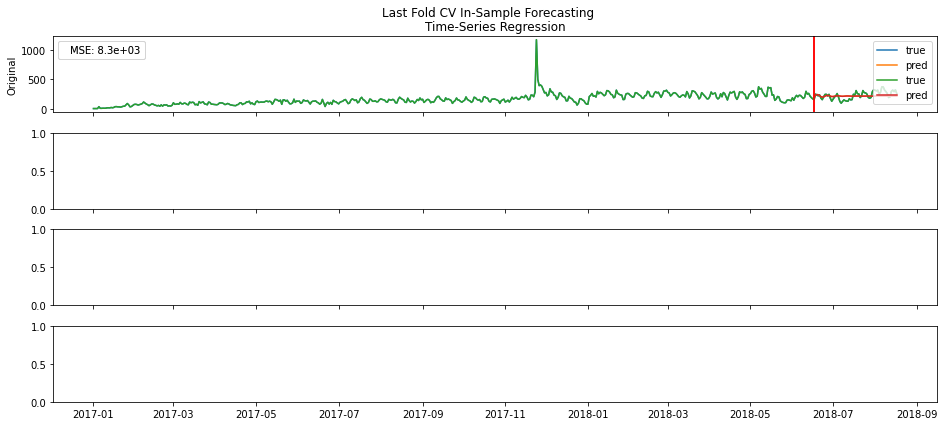

In [28]:
# Remove outliers
history = order_date[datetime.date(2017, 1, 1): datetime.date(2018, 8, 17)]
pred_period = pd.date_range(datetime.date(2018, 8, 17), datetime.date(2018, 10, 17))

title = 'Time-Series Regression'
data = history.copy()

#Data SPlitting
tscv = TimeSeriesSplit(max_train_size=pred_period.shape[0], test_size=pred_period.shape[0])

#set n-feature
N_FEATURES = 7

mse = []
for train_id, test_id in tscv.split(data):
    train, y_test = data.iloc[train_id], data.iloc[test_id]
    gen = TimeseriesGenerator(train, train, length=N_FEATURES, batch_size=1000)
    X_train = gen[0][0]
    y_train = gen[0][1]
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    X_pred = y_train[-N_FEATURES:].reshape(1,-1)
    y_pred = np.empty(y_test.shape[0])
    for i in range(len(y_pred)):
        forecast = lr.predict(X_pred)
        X_pred = np.delete(X_pred, 0, 1)
        X_pred = np.concatenate((X_pred, forecast.reshape(-1,1)), 1)    
        y_pred[i] = forecast
    mse.append(mean_squared_error(y_test, y_pred))
plot(y_test.index, y_pred, mse, title, figs, axs[0])